In [38]:
import pandas as pd 

import psana as ps
import numpy as np
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial as npply
import sys
import os
import h5py
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter as gf
from sklearn.utils import resample
sys.path.append('/reg/data/ana16/rix/rixlv1519/results/LCLS_LV15_2021/TestCode/EarlyScience/AnalyzeH5/')
from chemRIXSAnalysis import *
from ChemRIXSClasses import *
from filterTools import *
sys.path.append('/reg/data/ana16/rix/rixlv1519/results/LCLS_LV15_2021/Functions/')
from Functions import *
from Load_Scans import *
from raw_data_class import RawData as RDC
from pro_data_class import ProData as PDC
from raw_class_2 import RawData_2 as RDC_2


font = {'size'   : 16}
mpl.rc('font', **font)
%matplotlib widget
cmap = plt.cm.get_cmap('terrain').reversed()

In [39]:
exp = 'rixlw1019'
small_data_folder = '/reg/data/ana01/rix/%s/hdf5/smalldata/' % exp #changeme
scans = [99]
# raw = h5py.File(small_data_folder+'%s_Run%04d.h5' % (exp,scans))



In [135]:
raw = h5py.File(small_data_folder+'%s_Run%04d.h5' % (exp,scan))

xgmd = np.array(raw['xgmd']['energy'])
gmd = np.array(raw['gmd']['energy'])
energy_raw = np.array(raw['epicsAll']['MONO_ENERGY_EV'])
mono_encoder = np.array(raw['mono_encoder']['value'])
pitch_raw = np.array(raw['epicsAll']['MONO_GRATING_PITCH'])
horz_raw = np.array(raw['epicsAll']['MR3K4_pitch'])
evrs = np.array(raw['timing']['eventcodes'])
lxt = np.array(raw['epicsAll']['LAS_VIT_TIME'])
laser = np.array(raw['lightStatus']['laser'])

print(xgmd.shape)
print(gmd.shape)
print(energy_raw.shape)
print(mono_encoder.shape)
print(pitch_raw.shape)
print(horz_raw.shape)
print(evrs.shape)
print(lxt.shape)
print(laser.shape)
print((raw['rix_fim0_raw']['raw_0']).shape)

(59712,)
(59712,)
(59712,)
(59712, 1)
(59712,)
(59712,)
(59712, 256)
(59712,)
(59712,)
(59712, 256)


In [ ]:

# print(list(raw.keys()))

# fim2_raw = []
# for i in raw['rix_fim2_raw']:
#             fim0_raw.append(np.array((raw['rix_fim0_raw'][i])))
#         fim2_raw = np.moveaxis(np.asarray(fim2_raw),0,1)
        
# print(np.array(raw['rix_fim2_raw'])
raw_datas[0].andor_dir_raw.shape

In [40]:
raw_datas = []
for scan in scans:
    raw_data = load_scans_2_timestamp(small_data_folder,exp,scan)
    
    
    I0_intensities_fim0, I0_specs_fim0, baselines_fim0 = \
    process_fim(raw_data.fim0_raw,np.arange(0,8),np.arange(0,50),np.arange(105,220))
    
    I0_intensities_fim1, I0_specs_fim1, baselines_fim1 = \
    process_fim(raw_data.fim1_raw,np.arange(0,8),np.arange(0,50),np.arange(105,220))
    
    
    intensities_fim2, I0_specs_fim2, baselines_fim2 = \
    process_fim(raw_data.fim1_raw,np.arange(0,8),np.arange(200,250),np.arange(50,130))
        
    intensities_fim2=process_fim_2(raw_data.fim2_raw,np.arange(0,8))
    
    andor_dir_intensities, andor_dir_specs, baseline_andor_dir = \
    process_andor(raw_data.andor_dir_raw,np.arange(500,800),np.arange(900,1250))
    
    nan_cond_1 = np.logical_not(np.isnan(andor_dir_intensities))
    
    nan_cond_2 = np.logical_not(np.isnan(np.squeeze(raw_data.mono_encoder)))
    
    nan_cond_3 = np.logical_not(np.isnan(raw_data.energy_raw))
   
    nan_cond_4 = np.logical_not(np.isnan(raw_data.lxt))
    
    nan_cond_5 = np.logical_not(np.isnan(I0_intensities_fim0[4,:]))&np.logical_not(np.isnan(I0_intensities_fim0[5,:]))&\
                np.logical_not(np.isnan(I0_intensities_fim0[6,:]))&np.logical_not(np.isnan(I0_intensities_fim0[7,:]))
    
    nan_cond_6 = np.logical_not(np.isnan(I0_intensities_fim1[4,:]))&np.logical_not(np.isnan(I0_intensities_fim1[5,:]))&\
                np.logical_not(np.isnan(I0_intensities_fim1[6,:]))&np.logical_not(np.isnan(I0_intensities_fim1[7,:]))
    
    nan_cond_7 = np.logical_not(np.isnan(I0_intensities_fim1[6,:]))&np.logical_not(np.isnan(I0_intensities_fim1[7,:]))
    
    nan_cond_8 = np.logical_not(np.isnan(raw_data.xgmd))
    
    nan_cond_9 = np.logical_not(np.isnan(raw_data.gmd))
    
    nan_cond_10 = np.logical_not(np.isnan(raw_data.laser))
    
    
    
    nan_cond_11 = np.logical_not(np.isnan(raw_data.tt_pos)&np.isnan(raw_data.tt_posps))
    
    nan_cond = nan_cond_1&nan_cond_2&nan_cond_3&nan_cond_4&nan_cond_5&nan_cond_6&nan_cond_7&nan_cond_8&\
            nan_cond_9&nan_cond_10&nan_cond_11
    
    
    raw_data.energy_raw = raw_data.energy_raw[nan_cond]
    raw_data.mono_encoder = raw_data.mono_encoder[nan_cond]
    raw_data.lxt = raw_data.lxt[nan_cond]
    raw_data.tt_pos = raw_data.tt_pos[nan_cond]
    raw_data.tt_posps = raw_data.tt_posps[nan_cond]
    I0_intensities_fim0_new = []
    for i in range(0,8):
        new = I0_intensities_fim0[i][nan_cond]
        I0_intensities_fim0_new.append(new)
    I0_intensities_fim0_new = np.asarray(I0_intensities_fim0_new)
    I0_intensities_fim1_new = []
    for i in range(0,8):
        new = I0_intensities_fim1[i][nan_cond]
        I0_intensities_fim1_new.append(new)
    I0_intensities_fim1_new = np.asarray(I0_intensities_fim1_new)
    intensities_fim2_new = []
    for i in range(0,8):
        new = intensities_fim2[i][nan_cond]
        intensities_fim2_new.append(new)
    intensities_fim2_new = np.asarray(intensities_fim2_new)
    andor_dir_intensities = andor_dir_intensities[nan_cond]
    raw_data.xgmd = raw_data.xgmd[nan_cond]
    raw_data.gmd = raw_data.gmd[nan_cond]
    raw_data.event = raw_data.event[nan_cond]
    
    
    
    
    raw_data.changeValue(I0_intensities_fim0=I0_intensities_fim0_new,
                        I0_specs_fim0=I0_specs_fim0,
                        baselines_fim0=baselines_fim0,
                        I0_intensities_fim1=I0_intensities_fim1_new,
                        I0_specs_fim1=I0_specs_fim1,
                        baselines_fim1=baselines_fim1,
                        intensities_fim2=intensities_fim2_new,
                        andor_dir_intensities=andor_dir_intensities,
                        andor_dir_specs=andor_dir_specs,
                        baseline_andor_dir=baseline_andor_dir,
                        )
    
    
    raw_datas = raw_datas + [raw_data]
# print(raw_datas[0].getKeys())
print(raw_datas[0].andor_dir_intensities.shape)
# print(raw_datas[0].timestamp.shape)
# print(np.max(raw_datas[0].tt_posps))
# print(np.min(raw_datas[0].tt_posps))

loading TT
loading fim0
loading fim1
loading andor
loading fim2
(18396,)


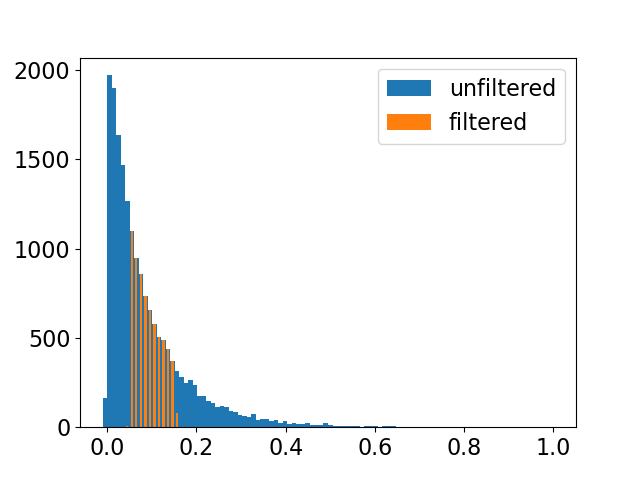

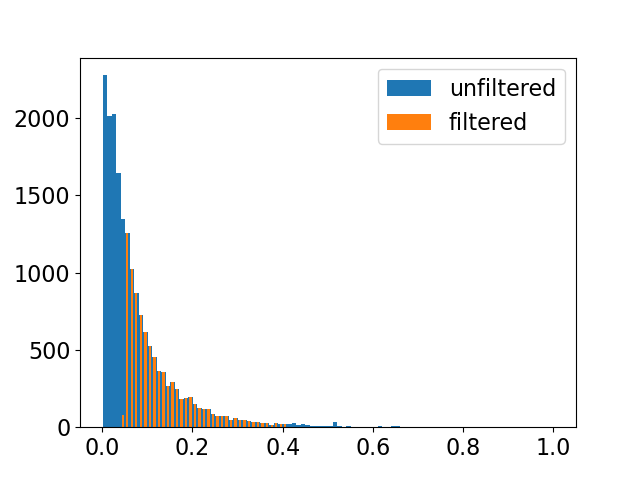

In [42]:
scans_to_plot = [0]
n_bins = 100
# plt.figure()
to_average = []
fim0_channels = [5,7]#,5,6,7]
fim1_channels = [6,7]
for scan in scans_to_plot:
    all_events = raw_datas[scan].event
    nan_cond = np.logical_not(np.isnan(np.squeeze(raw_datas[scan].mono_encoder)))
    
    x_axis = np.squeeze(raw_datas[scan].mono_encoder)[nan_cond]
    andor = raw_datas[scan].andor_dir_intensities[nan_cond]
    
    
    fim_0 = np.sum(raw_datas[scan].I0_intensities_fim0[fim0_channels,:],0)
    fim_1 = np.sum(raw_datas[scan].I0_intensities_fim1[fim1_channels,:],0)
    
#     all_Izero = fim_0
#     all_Izero = fim_1
    all_Izero = np.sum(np.array((fim_0,fim_1)),0)[nan_cond]
    
#     fim_0 = raw_datas[scan].I0_intensities_fim1[7,:]


    B_condition_1 = bounds_filter(all_Izero/np.max(all_Izero)\
                                  ,[[0.05,'None'],[1]],True) 
    B_condition_2 = bounds_filter(andor/np.max(andor)\
                                  ,[[0.05,'None'],[4]],True) 
    bounds_conditions = B_condition_1 & B_condition_2
    

    x_value = x_axis[bounds_conditions]
    y_value = all_Izero[nan_cond][bounds_conditions]
    bins, Izero_binned_means, Izero_binned_shots = energy_binning(x_value,y_value,n_bins)

    y_value = andor[nan_cond][bounds_conditions]
    bins, andor_binned_means, andor_binned_shots = energy_binning(x_value,y_value,n_bins)

    y_value = all_events[nan_cond][bounds_conditions]
    bins, trash, events_binned = energy_binning(x_value,y_value,n_bins)
    
    lin_conditions = []
    plot = False
    for i in range(0,n_bins-1):
#             if i is 10:
#                 plot = True
            lin_conditions.append(lin_filter(Izero_binned_shots[i],\
                               andor_binned_shots[i],[0.01,False],plot))
            plot = False
    lin_conditions = np.asarray(lin_conditions,dtype=object)

    andor_filt_and_binned = np.asarray([andor_shots[lin_cond] \
                                        for andor_shots,lin_cond in zip(andor_binned_shots,lin_conditions)],dtype=object)
    Izero_filt_and_binned = np.asarray([Izero_shots[lin_cond] \
                                        for Izero_shots,lin_cond in zip(Izero_binned_shots,lin_conditions)],dtype=object)

    
    events_filt_and_binned = np.asarray([events_binned[lin_cond] \
                                        for events_binned,lin_cond in zip(events_binned,lin_conditions)],dtype=object)

    norm_then_mean = np.asarray([np.mean(x) for x in andor_filt_and_binned/Izero_filt_and_binned])
    mean_then_norm = np.asarray([np.mean(x)/np.mean(y) for x,y in zip(andor_filt_and_binned,Izero_filt_and_binned)])
    to_average.append(norm_then_mean)
#     plt.figure()
#     plt.plot(bins[0:-1],norm_then_mean)
#     plt.plot(bins[0:-1],mean_then_norm)
# plt.show()
# average = np.mean(np.asarray(to_average),0)

# plt.figure()
# plt.plot(bins[0:-1],average)


In [43]:
# def energy_binning(x_value,y_value,n_bins):
#     vernier_energy = np.squeeze(x_value)
#     bins = np.linspace(np.min(vernier_energy),np.max(vernier_energy),n_bins)
#     intensity=[]
#     shots = []
#     for i in range(0,len(bins)-1):
#         bin_cond = np.logical_and(vernier_energy>=bins[i],vernier_energy<=bins[i+1])
#         shots.append(y_value[bin_cond])
#         intensity.append(np.mean(y_value[bin_cond]))
#     intensity = np.asarray(intensity)
#     shots = np.asarray(shots,dtype=object)
#     return bins,intensity,shots

# for i in range (len(n_bins)):
#     vars_to_bin = ['I0_intensities_fim0','I0_intensities_fim1','intensities_fim2','andor_dir_intensities']

#     binned_vals_time = PDC()

time_step = 100

tt_posps_min = np.min(raw_datas[0].tt_posps)

tt_posps_max = np.max(raw_datas[0].tt_posps)

n_time_bins = round((tt_posps_max - tt_posps_min)/time_step)

print(n_time_bins)

x_values = raw_datas[0].tt_posps
y_values = raw_datas[0].event
time_bins = []
time_shots = []
for i in range(n_time_bins):
    if i < n_time_bins - 1:
        bin_cond = np.logical_and(x_values >= tt_posps_min + time_step*i, x_values < tt_posps_min + time_step*(i+1))
        time_bins.append(x_values[bin_cond])
        time_shots.append(y_values[bin_cond])
    else:
        bin_cond = x_values <= (tt_posps_min + time_step*(i+1))
        time_bins.append(x_values[bin_cond])
        time_shots.append(y_values[bin_cond])

time_shots = np.array(time_shots,dtype=object)
time_bins = np.array(time_bins)
# means = {var_to_bin+'_time_binned_mean':time_intensity}
# shots = {var_to_bin+'_time_binned':time_shots}
# binned_vals_time.__dict__.update(means)
# binned_vals_time.__dict__.update(shots)

time_andor = [None]* n_time_bins
time_events = [None] * n_time_bins

for i in range (n_time_bins):
    for j in range (n_bins):
        time_events[i] = set(time_shots[i]).intersection(set(events_filt_and_binned[j]))
        time_andor[i] = andor_filt_and_binned[j][(time_shots[i]==evens_filts_and_binned[j])] 
        

    
#     cond = andor_filt_and_dasd[i].event.intersection(binned_val_time_binned)
# #     andor_filt_and_time = andor_filt_and_dasd[cond]
# print(time_shots[0])
# /

2


/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


NameError: name 'evens_filts_and_binned' is not defined

In [12]:

# vars_to_bin = ['I0_intensities_fim0','I0_intensities_fim1','intensities_fim2','andor_dir_intensities']

# nan_cond = np.logical_not(np.isnan(np.squeeze(raw_datas[0].mono_encoder)))

# binned_vals = PDC()

# print(np.squeeze(raw_datas[0].timestamp).shape)

# bin_time = 1000
# for var_to_bin in vars_to_bin:
#     x_value = np.squeeze(raw_datas[0].timestamp)[nan_cond] 
#     y_value = np.transpose(getattr(raw_datas[0],var_to_bin))[nan_cond]
#     n_bins = round(len(x_value)/bin_time)
#     time_bins = []
#     time_intensity=[]
#     time_shots = []
#     for i in range(0,n_bins):
#         if i < n_bins - 1:
#             time_shots.append(y_value[i*bin_time:(i+1)*bin_time])
#             time_intensity.append(np.mean(y_value[i*bin_time:(i+1)*bin_time]))
#         else:
#             time_shots.append(y_value[i*bin_time:(i+1)*bin_time])
#             time_intensity.append(np.mean(y_value[i*bin_time:]))
#     time_intensity = np.asarray(time_intensity)
#     time_shots = np.asarray(time_shots,dtype=object)
    
#     means = {var_to_bin+'_time_binned_mean':time_intensity}
#     shots = {var_to_bin+'_time_binned':time_shots}
#     binned_vals.__dict__.update(time_means)
#     binned_vals.__dict__.update(time_shots)
# #     print(binned_vals.andor_dir_intensities_time_binned.shape)
    
# # print(binned_vals.getKeys())

# # print(binned_vals.I0_intensities_fim0_time_binned)

(58627,)


In [57]:
vars_to_bin = ['I0_intensities_fim0','I0_intensities_fim1','intensities_fim2','andor_dir_intensities']

nan_cond = np.logical_not(np.isnan(np.squeeze(raw_datas[0].mono_encoder)))

binned_vals = PDC()
n_bins = 100
for var_to_bin in vars_to_bin:
    x_value = np.squeeze(raw_datas[0].mono_encoder)[nan_cond]
    y_value = np.transpose(getattr(raw_datas[0],var_to_bin))[nan_cond]
    bins, mean_val, shot_by_shot = energy_binning(x_value,y_value,n_bins)
    
# #     for i in range (n_bins):
# #         x_vals = mono_binned[i]
# #         y_vals = shot_by_shot
# #         scale = np.max([x_vals,y_vals])
# #         m, _, _, _ = np.linalg.lstsq(x_vals,y_vals)
# #         cond_lin_high = y_vals < x_vals * m + scale*1
# #         cond_lin_low = y_vals > x_vals * m - scale*1
# #         bin_condition = cond_lin_high & cond_lin_low
        
# #         shot_by_shot[i] = shot_by_shot[i][bin_condition]
        
    means = {var_to_bin+'_binned_mean':mean_val}
    shots = {var_to_bin+'_binned':shot_by_shot}
    binned_vals.__dict__.update(means)
    binned_vals.__dict__.update(shots)
    
print(binned_vals.getKeys())

print(binned_vals.I0_intensities_fim0_binned[0].shape)

print(binned_vals.andor_dir_intensities_binned[0].shape)

# for i in range (n_bins):
#     y_vals = binned_vals.andor_dir_intensities_binned[i]
#     x_vals = binned_vals.I0_intensities_fim0_binned[i][:,4]
#     scale = np.max([x_vals,y_vals])
#     scale = 1
#     a,b,c = np.polyfit(x_vals,y_vals)
#     cond_lin_high = y_vals < np.square(x_vals) * a + x_vals * b + c
#     cond_lin_low = y_vals > x_vals * m - scale*1
#     bin_condition = cond_lin_high & cond_lin_low

#     binned_vals.I0_intensities_fim0_binned[i][:,4] = binned_vals.I0_intensities_fim0_binned[i][5][bin_condition]
#     binned_vals.andor_dir_intensities_binned[i] = binned_vals.andor_dir_intensities_binned[i][bin_condition]

# # print(binned_vals.andor_dir_intensities_binned_mean)

dict_keys(['condition', 'I0_intensities_fim0_binned_mean', 'I0_intensities_fim0_binned', 'I0_intensities_fim1_binned_mean', 'I0_intensities_fim1_binned', 'intensities_fim2_binned_mean', 'intensities_fim2_binned', 'andor_dir_intensities_binned_mean', 'andor_dir_intensities_binned'])
(1243, 8)
(1243,)


99


<Figure size 640x480 with 0 Axes>

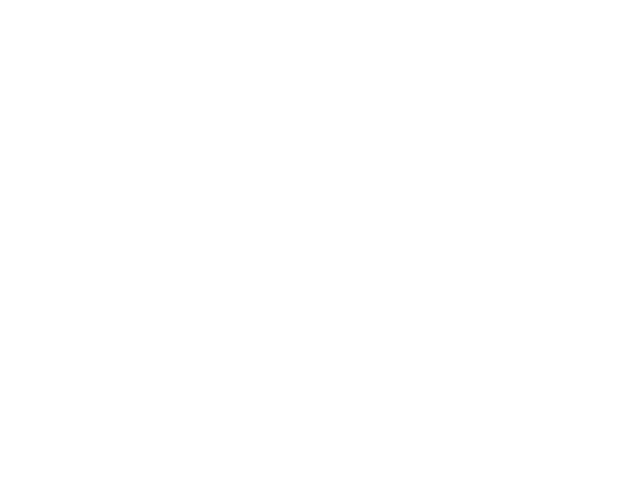

In [22]:
# print(binned_vals.timestamp_binned[0])
print(len(binned_vals.andor_dir_intensities_binned.flatten()))
plt.figure()
# plt.plot(binned_vals.timestamp_binned.flatten(),binned_vals.andor_dir_intensities_binned.flatten())


In [17]:
andor = raw_datas[0].andor_dir_intensities[nan_cond]
Izero = raw_datas[0].I0_intensities_fim1[5,:][nan_cond]

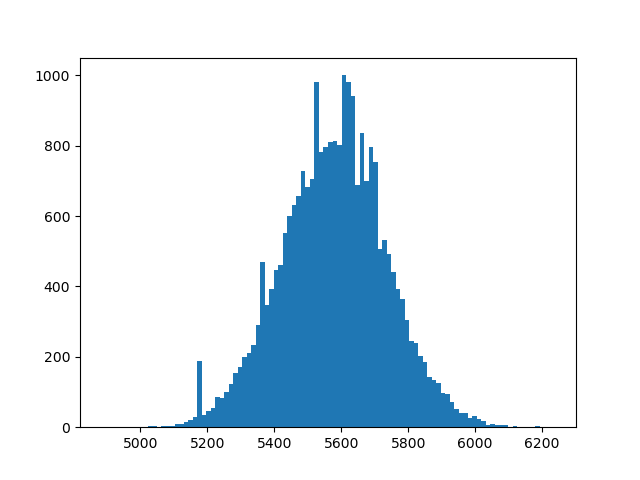

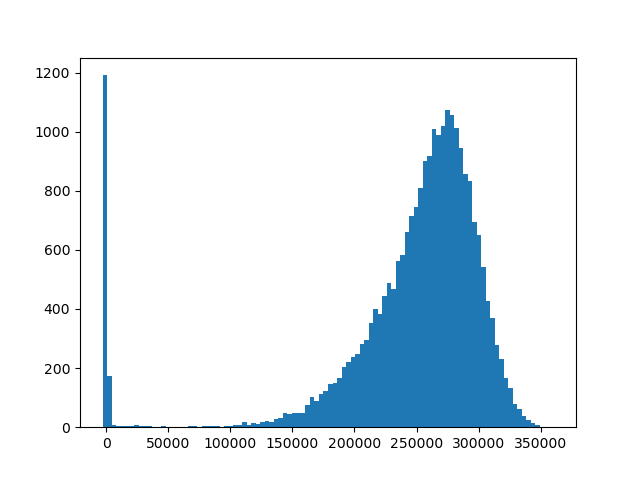

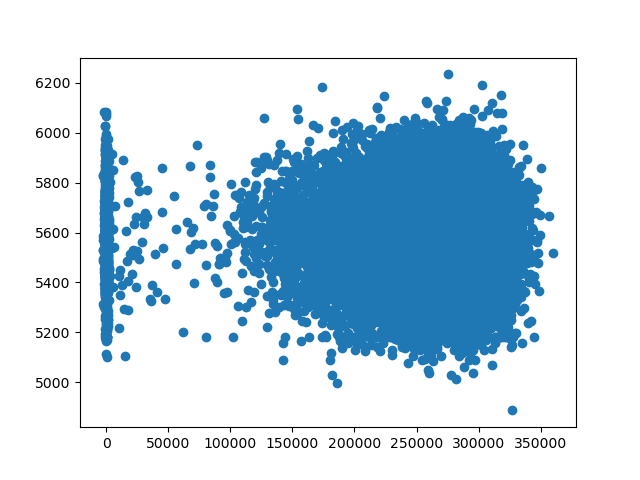

In [18]:
plt.close('all')
andor = raw_datas[0].andor_dir_intensities[nan_cond]
Izero = raw_datas[0].I0_intensities_fim1[5,:][nan_cond]
plt.figure()
_, bins, _ = plt.hist(andor, 100)#, label='unfiltered')

plt.figure()
_, bins, _ = plt.hist(Izero, 100)#, label='unfiltered')

plt.figure()
plt.scatter(Izero,andor)

for i in range (n_bins):
    = np.polyfit()

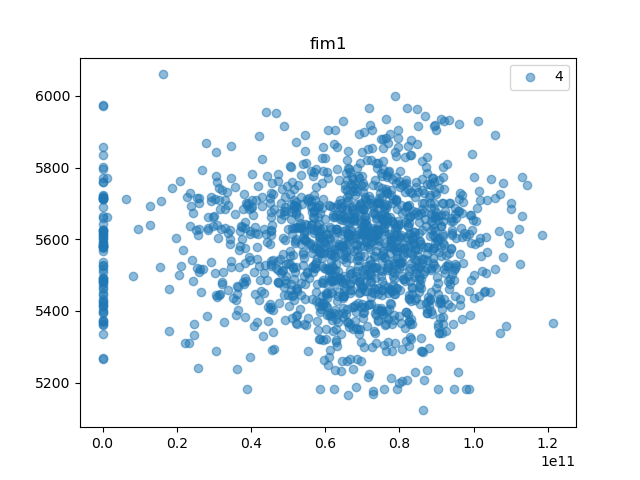

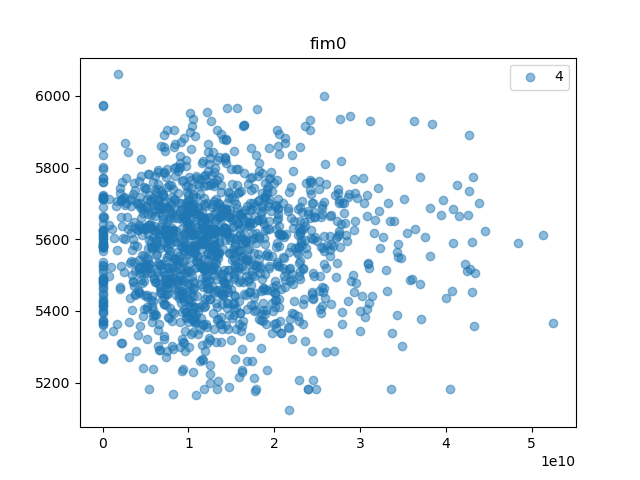

In [19]:
plt.close('all')
## correlation filter between I0 and detector at each energy binx
# plt.figure()
# plt.scatter(np.squeeze(np.sum(raw_datas[0].I0_intensities_fim0[4:7,:],0)),raw_datas[0].andor_dir_intensities,alpha=0.05)
# plt.scatter(np.squeeze(np.sum(raw_datas[0].I0_intensities_fim0[4:7,:],0)),raw_datas[0].andor_dir_intensities,alpha=0.05)
# plt.figure()
# plt.scatter(raw_datas[0].I0_intensities_fim0[5,:],raw_datas[0].andor_dir_intensities,alpha=0.05)
for i in range(5,6):
    plt.figure(10)
    plt.scatter(binned_vals.I0_intensities_fim1_binned[50][:,i]**2,binned_vals.andor_dir_intensities_binned[50],alpha=0.5)
    plt.title('fim1')
    plt.legend(('4','5','6','7'))
    plt.show()
    
    plt.figure(11)
    plt.scatter(binned_vals.I0_intensities_fim0_binned[50][:,i]**2,binned_vals.andor_dir_intensities_binned[50],alpha=0.5)
    plt.title('fim0')
    plt.legend(('4','5','6','7'))
    plt.show()
    

# for i in range(0,len(binned_vals.andor_dir_intensities_binned)):
#     if i%10 is 0:
#         plt.scatter(binned_vals.I0_intensities_fim1_binned[i][:,5],binned_vals.andor_dir_intensities_binned[i],alpha=0.5)

In [ ]:
# lin_fit = np.polyfit(raw_datas[0].I0_intensities_fim1[5,:],raw_datas[0].andor_dir_intensities, 2)
# lin_fit

var_x = raw_datas[0].I0_intensities_fim1[5,:]
var_y = raw_datas[0].andor_dir_intensities
scale = np.max([var_x,var_y])
lin_fit = np.polyfit(var_x, var_y, 1)
cond_lin_high = var_y < var_x * lin_fit[0] + lin_fit[1] + 0.05*scale
cond_lin_low = var_y > var_x * lin_fit[0] + lin_fit[1] - 0.05*scale
condition = cond_lin_high & cond_lin_low






plt.figure()
plt.scatter(var_x,var_y)

Text(0.5, 1.0, 'Mean Waveform Andor')

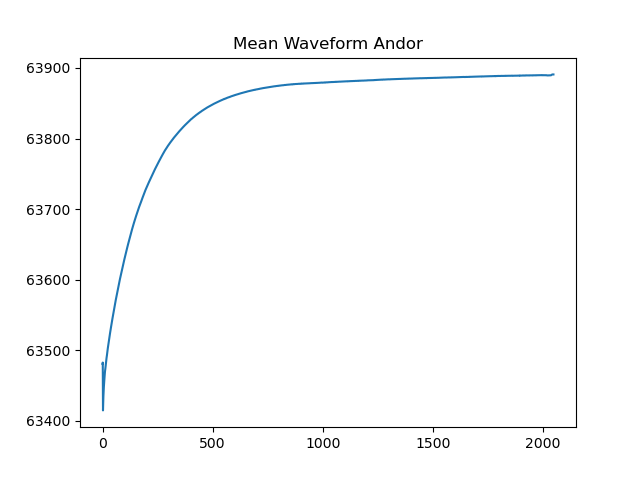

In [23]:
# raw_datas[0].getKeys()
# raw_datas[0].I0_specs_fim0[0,:].shape
# mean_waveform = np.mean(raw_datas[0].fim2_raw,0)
# mean_waveform.shape
# plt.figure()
# plt.plot(mean_waveform[0])
# plt.title('Mean Waveform Fim1 - Channel 7 - Run 28')

plt.figure()
plt.plot(np.mean(raw_datas[0].andor_dir_raw,0))
# plt.plot(np.mean(raw_datas[1].andor_dir_raw,0))

plt.title('Mean Waveform Andor')

# # raw_datas[0].andor_dir_raw.shape

In [ ]:
fim1= (raw_datas[0].I0_intensities_fim1[[5,6,7],:]).flatten()
fim0 = (raw_datas[0].I0_intensities_fim0[[5,6,7],:]).flatten()

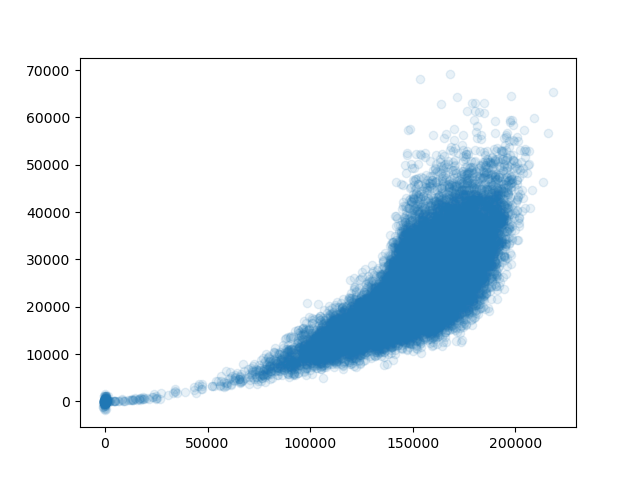

In [43]:
# plt.close('all')
# plt.figure()
# plt.plot(np.mean(raw_datas[0].andor_dir_raw,0))
# # plt.plot(np.mean(raw_datas[0].andor_dir_specs-raw_datas[0].baseline_andor_dir[:,np.newaxis],0))
# # np.sum(np.mean(raw_datas[0].andor_dir_specs-raw_datas[0].baseline_andor_dir[:,np.newaxis],0))
# # raw_datas[0].andor_dir_specs.shape
# # raw_datas[0].andor_dir_raw.shape

x = 5
y = 
plt.close('all')
plt.figure()
plt.scatter(raw_datas[0].I0_intensities_fim1[x,:],raw_datas[0].I0_intensities_fim1[y,:],alpha =0.1)


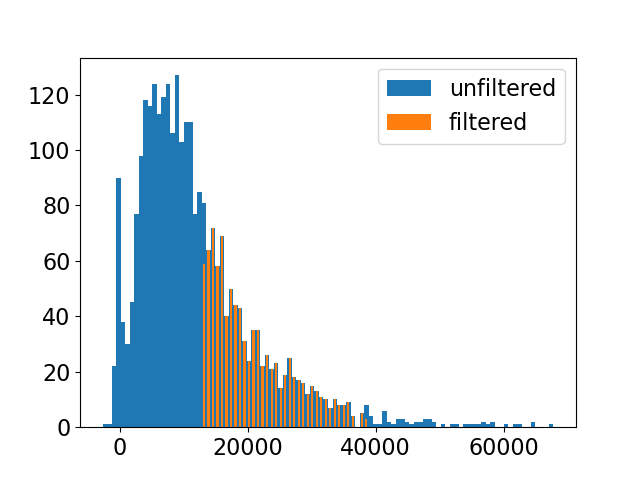

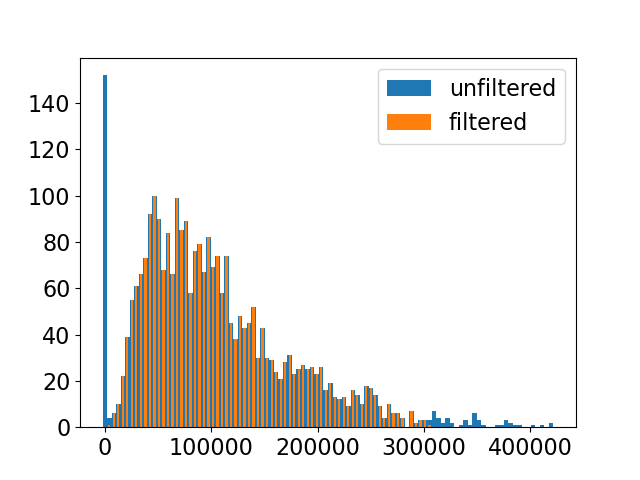

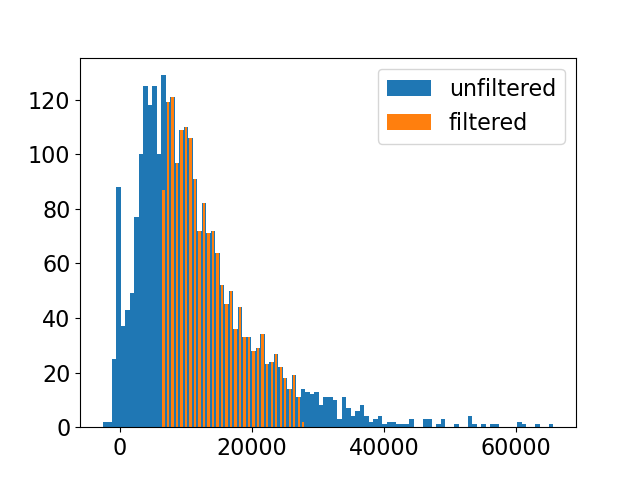

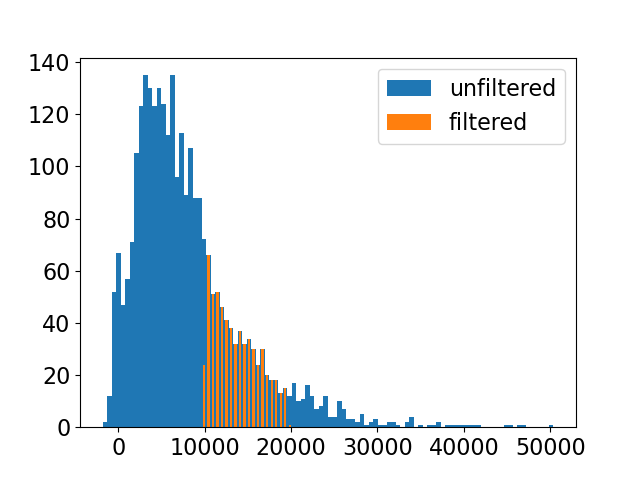

In [28]:
plt.close('all')
filter_params = []
for raw in raw_datas:
    filter_param = PDC()
    
    B_condition_1 = bounds_filter(raw.I0_intensities_fim1[4,:],[[13000,'None'],[3]],True) 
    B_condition_2 = bounds_filter(raw.I0_intensities_fim1[5,:],[[5000,'None'],[3]],True) 
    B_condition_3 = bounds_filter(raw.I0_intensities_fim1[6,:],[[6500,'None'],[2]],True) 
    B_condition_4 = bounds_filter(raw.I0_intensities_fim1[7,:],[[10000,'None'],[2]],True) 

    # raw.I0_intensities_fim0[4,:] is I0 intensities from fim0 channel 4


    bounds_condition = B_condition_1 & B_condition_2 & B_condition_3 & B_condition_4

    L_condition_1 = lin_filter(raw.I0_intensities_fim1[5,:], raw.andor_dir_intensities,[0.05,False],False)


    linearity_condition = L_condition_1
    condition = bounds_condition# & linearity_condition
    
    filter_param.changeValue(condition=condition)
    filter_params = filter_params + [filter_param]
    


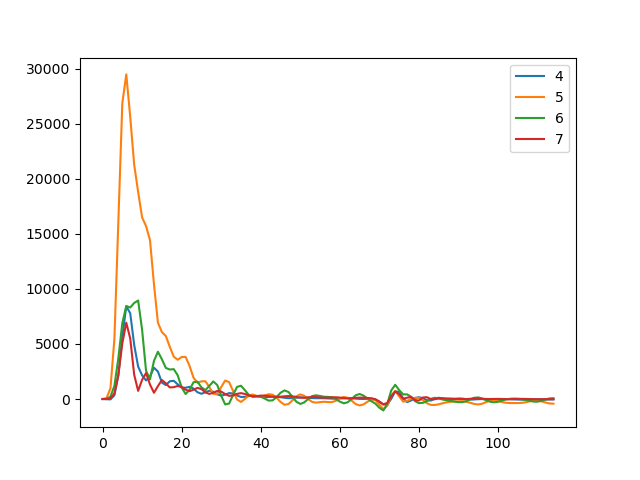

In [48]:
# # plt.figure()
# plt.plot(np.mean(raw_datas[0].fim1_raw[:,7,:],0))
# # plt.show()
# raw_datas[0].fim1_raw[:,4,:].shape
# plt.legend(('4','5','6','7'))
# plt.show()

plt.figure()
for i in range(4,8):
    plt.plot(-np.mean(raw_datas[0].I0_specs_fim1[i,:]-raw_datas[0].baselines_fim1[i,:,np.newaxis],0))
plt.legend(('4','5','6','7'))
plt.show()

# plt.figure()
# plt.scatter(raw_datas[0].andor_dir_intensities,raw_datas[0].I0_intensities_fim1[4,:],alpha=0.01)
# raw_datas[0].I0_specs_fim0[i,:].shape
# raw_datas[0].baselines_fim0[i,:,np.newaxis].shape

In [29]:
# scan_type = 'mono'
scan_type = 'time'

pro_datas = []
for i in range(0,len(raw_datas)):
    pro_data = PDC()
    pumped = raw_datas[i].laser==1
    unpumped = raw_datas[i].laser==0
    condition = filter_params[i].condition
    
#     norm_by = np.square(np.mean(raw_datas[i].I0_intensities_fim1[4:7,:],0))
    norm_by = np.square(raw_datas[i].I0_intensities_fim1[5,:])

    
    if scan_type is 'mono':

        n_bins = 100
        mono_encoder_ev = np.squeeze(mono_calib(raw_datas[i].energy_raw,raw_datas[i].mono_encoder))
        
#         x_vals = np.squeeze(raw_datas[i].mono_encoder)#mono_encoder_ev
        x_vals = mono_encoder_ev

        y_vals = raw_datas[i].andor_dir_intensities
#         y_vals = raw_datas[i].intensities_fim2[0,:]
#         y_vals = np.sum(raw_datas[i].andor_dir_specs,1)
#         y_vals = norm_by
        
        ##### pumped #####
        energy,intensity_raw_pumped = \
        mono_spectrum(x_vals[pumped],n_bins,y_vals[pumped])
        
        energy,intensity_filtered_pumped = \
        mono_spectrum(x_vals[condition&pumped],n_bins,y_vals[condition&pumped])
        
        energy,intensity_norm_filtered_pumped = \
        mono_spectrum(x_vals[condition&pumped],n_bins,y_vals[condition&pumped]/norm_by[condition&pumped])
        
        ##### unpumped #####
        energy,intensity_raw_unpumped = \
        mono_spectrum(x_vals[unpumped],n_bins,y_vals[unpumped])
        
        energy,intensity_filtered_unpumped = \
        mono_spectrum(x_vals[condition&unpumped],n_bins,y_vals[condition&unpumped])
        
        energy,intensity_norm_filtered_unpumped = \
        mono_spectrum(x_vals[condition&unpumped],n_bins,y_vals[condition&unpumped]/norm_by[condition&unpumped])

        
        pro_data.changeValue(energy=energy,
                             intensity_raw_pumped = intensity_raw_pumped,
                             intensity_filtered_pumped = intensity_filtered_pumped,
                             intensity_norm_filtered_pumped = intensity_norm_filtered_pumped,
                             intensity_raw_unpumped = intensity_raw_unpumped,
                             intensity_filtered_unpumped = intensity_filtered_unpumped,
                             intensity_norm_filtered_unpumped = intensity_norm_filtered_unpumped)
        
        pro_datas = pro_datas + [pro_data]
        
    if scan_type is 'time':
        
        x_vals = raw_datas[i].lxt
        
        y_vals = raw_datas[i].andor_dir_intensities
        
        #pumped
        d_bins_raw, andor_intensities_time_raw = time_scan(x_vals,y_vals)
        
        d_bins_filt, andor_intensities_time_filt = time_scan(x_vals[condition],y_vals[condition])
        
        andor_intensities_time_norm_filt = \
        time_scan(x_vals[condition&unpumped],y_vals[condition&unpumped]/norm_by[condition&unpumped])[1]
        
        #unpumped
        andor_intensities_time_raw_pumped = time_scan(x_vals[pumped],y_vals[pumped])[1]
        
        andor_intensities_time_filt_pumped = time_scan(x_vals[condition&pumped],y_vals[condition&pumped])[1]
        
        andor_intensities_time_norm_filt_pumped = \
        time_scan(x_vals[condition&pumped],y_vals[condition&pumped]/norm_by[condition&pumped])[1]
        
        pro_data.changeValue(d_bins_raw=d_bins_raw,
                             andor_intensities_time_raw=andor_intensities_time_raw,
                             andor_intensities_time_filt=andor_intensities_time_filt,
                             d_bins_filt=d_bins_filt,
                             andor_intensities_time_norm_filt = andor_intensities_time_norm_filt,
                             andor_intensities_time_raw_pumped = andor_intensities_time_raw_pumped,
                             andor_intensities_time_filt_pumped = andor_intensities_time_filt_pumped,
                             andor_intensities_time_norm_filt_pumped =andor_intensities_time_norm_filt_pumped
                            )
        
        pro_datas = pro_datas + [pro_data]
        

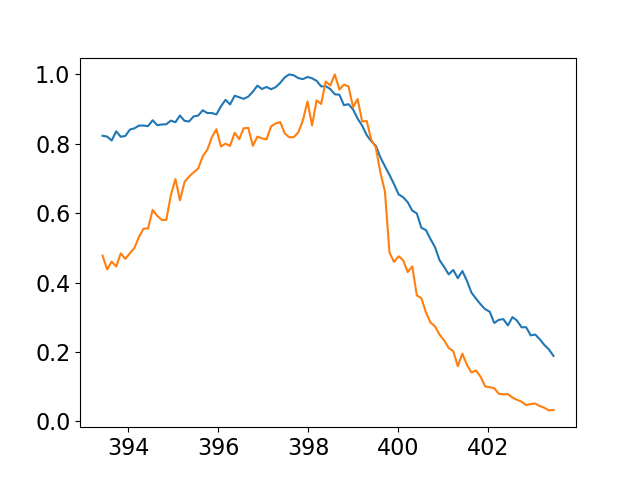

In [55]:
plt.close('all')
# plt.figure()
# plt.plot(pro_datas[1].energy,pro_datas[1].intensity_raw_pumped)
# plt.plot(pro_datas[1].energy,pro_datas[1].intensity_filtered_pumped)
# plt.show()

# # plt.figure()
# # plt.plot(pro_datas[1].energy,pro_datas[1].intensity_raw_pumped)
# # plt.plot(pro_datas[1].energy,pro_datas[1].intensity_filtered_pumped)
# # plt.show()

plt.figure(10)
plt.plot(pro_datas[0].energy,pro_datas[0].intensity_norm_filtered_pumped/np.max(pro_datas[0].intensity_norm_filtered_pumped))
plt.plot(pro_datas[0].energy,pro_datas[0].intensity_raw_pumped/np.max(pro_datas[0].intensity_raw_pumped))
# plt.legend(('4','5','6','7'))
plt.show()


# plt.figure(11)
# plt.plot(pro_datas[0].energy,pro_datas[0].intensity_raw_pumped/np.max(pro_datas[0].intensity_raw_pumped))
# # plt.plot(pro_datas[1].energy,pro_datas[1].intensity_norm_filtered_pumped)
# plt.legend(('4','5','6','7'))
# plt.show()

# plt.figure(11)
# plt.plot(np.mean(raw_datas[0].fim1_raw[:,7,:],0))
# # plt.show()
# # raw_datas[0].fim1_raw[:,5,:].shape
# plt.legend(('4','5','6','7'))
# plt.show()
# raw_datas[i].mono_encoder.shape

In [37]:
# mono_encoder_ev = np.squeeze(mono_calib(raw_datas[1].energy_raw,raw_datas[1].mono_encoder))


energy,intensity_raw = \
mono_spectrum(raw_datas[1].mono_encoder,n_bins,raw_datas[1].mono_encoder)

# plt.figure()
# plt.plot(raw_datas[1].mono_encoder)#,raw_datas[1].andor_dir_intensities)
n_bins = 10
bins = np.linspace(np.min(raw_datas[1].mono_encoder),np.max(raw_datas[1].mono_encoder),n_bins)

print(bins)
print(np.min(raw_datas[1].mono_encoder))
print(np.max(raw_datas[1].mono_encoder))
test = np.squeeze(raw_datas[1].mono_encoder)
intensity=[]
lower_bound = bins[0]
for i in range(0,len(bins)-1):
    bin_cond = np.logical_and(test>bins[i],test<bins[i+1])
    intensity.append(np.sum(raw_datas[1].andor_dir_intensities[bin_cond]))
intensity = np.asarray(intensity)

IndexError: list index out of range

In [ ]:
# plt.figure()
# plt.scatter(np.square(raw_datas[0].I0_intensities_fim1[5,:]), raw_datas[0].andor_dir_intensities,alpha=0.1)
# np.squeeze(raw_datas[1].mono_encoder).shape

# test = np.squeeze(raw_datas[1].mono_encoder)
# print(test.shape)
# print(test[np.logical_and(test<bins[1],test>bins[0])].shape)

y_value = raw_datas[0].andor_dir_intensities

n_bins = 50
vernier_energy = np.squeeze(raw_datas[1].mono_encoder)
bins = np.linspace(np.min(vernier_energy),np.max(vernier_energy),n_bins)


intensity=[]
for i in range(0,len(bins)-1):
    bin_cond = np.logical_and(vernier_energy>=bins[i],vernier_energy<=bins[i+1])
    intensity.append(np.sum(y_value[bin_cond]))
intensity = np.asarray(intensity)
plt.figure()
plt.plot(intensity)

NameError: name 'bins' is not defined

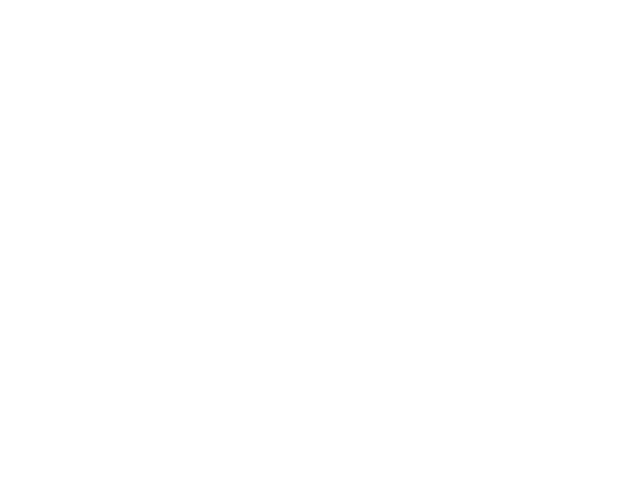

In [57]:
plt.close('all')
data = raw_datas[0]
cond = filter_params[0].condition
norm_by = np.square(raw_datas[0].I0_intensities_fim1[5,:])
y_value = data.andor_dir_intensities/norm_by
# y_value = np.mean(data.I0_intensities_fim0[4:7,:],0)
x_value = data.mono_encoder
n_bins = 150
bins,intensity,shots = energy_binning(x_value[cond],y_value[cond],n_bins)

plt.figure()
plt.plot(bins[0:-1],intensity)

plt.figure()
# _, bins, _ = plt.hist(shots)#, 100, label='unfiltered')
plt.plot(bins[0:-1],shots)